# AKARI-SEP master catalogue
## Preparation of DES DR2 data

Blanco DES catalogue: the catalogue comes from `dmu0_DES`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The G band stellarity;
- The magnitude for each band.
- The auto/kron magnitudes/fluxes to be used as total magnitude.
- The aperture magnitudes, which are used to compute a corrected 2 arcsec aperture magnitude.

We don't know when the maps have been observed. We will take the final observation date as 2017.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0575207 (Wed Apr 28 17:44:47 2021 +0100)
This notebook was executed on: 
2021-06-18 15:00:57.491021


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates, \
                                            nb_plot_mag_ap_evol, nb_plot_mag_vs_apcor 
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, flux_to_mag, aperture_correction

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "des_ra"
DEC_COL = "des_dec"

In [4]:
# Pristine HSC catalogue
INPUT_CAT = "../../dmu0/dmu0_DES/data/des-dr2-adfs.fits"
orig_des = Table.read(INPUT_CAT)

## 1 - Aperture correction

To compute aperture correction we need to dertermine two parametres: the target aperture and the range of magnitudes for the stars that will be used to compute the correction.

Target aperture: To determine the target aperture, we simulate a curve of growth using the provided apertures and draw two figures:

The evolution of the magnitudes of the objects by plotting on the same plot aperture number vs the mean magnitude.
The mean gain (loss when negative) of magnitude is each aperture compared to the previous (except for the first of course).
As target aperture, we should use the smallest (i.e. less noisy) aperture for which most of the flux is captures.

Magnitude range: To know what limits in aperture to use when doing the aperture correction, we plot for each magnitude bin the correction that is computed and its RMS. We should then use the wide limits (to use more stars) where the correction is stable and with few dispersion.

In [5]:
bands = ["g", "r", "i", "z", "y"]
apertures = ["1", "2", "3", "4",  "5", "6", "7", "8", "9", "10", "11"] #Removed "40" and "235" because they lack errors

magnitudes = {}
stellarities = {}

for band in bands:
    magnitudes[band] = np.array(
        [orig_des["MAG_APER_{}_{}".format(aperture, band.upper())] for aperture in apertures]
    )

    stellarities[band] = np.array(orig_des["CLASS_STAR_{}".format(band.upper())])
    
    # Some sources have an infinite magnitude
    mask = np.isclose(magnitudes[band], 99.)
    magnitudes[band][mask] = np.nan

    
mag_corr = {}

### I.a - g band

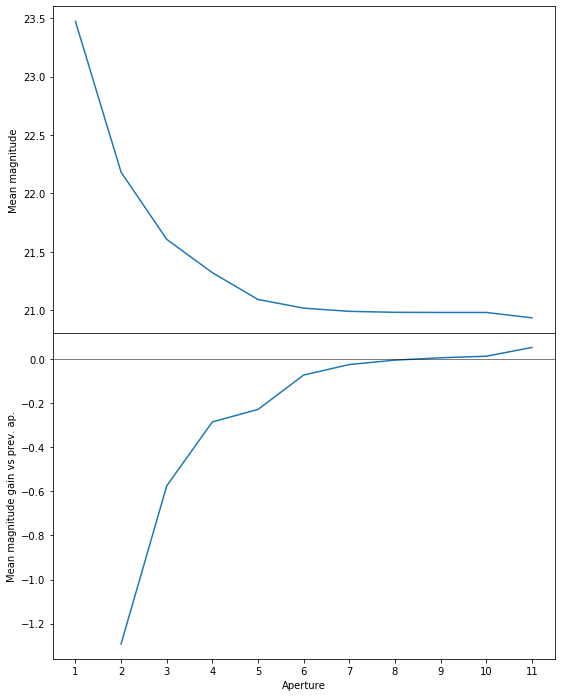

In [6]:

nb_plot_mag_ap_evol(magnitudes['g'], stellarities['g'], labels=apertures)

We will use aperture 10 as target.

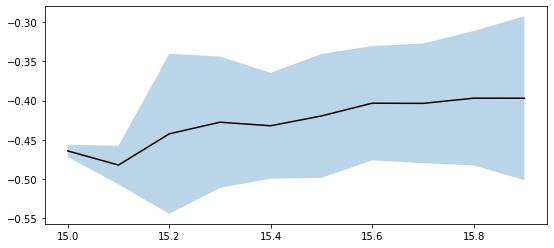

In [7]:
nb_plot_mag_vs_apcor(orig_des['MAG_APER_4_G'], orig_des['MAG_APER_10_G'], stellarities['g'])


We will use magnitudes between 15.0 and 16.0

In [8]:
# Aperture correction
mag_corr['g'], num, std = aperture_correction(
    orig_des['MAG_APER_4_G'], orig_des['MAG_APER_10_G'], 
    stellarities['g'],
    mag_min=15.0, mag_max=16.0)
print("Aperture correction for g band:")
print("Correction: {}".format(mag_corr['g']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for g band:
Correction: -0.4023561477661133
Number of source used: 3353
RMS: 0.08339773269944677


### I.b - r band

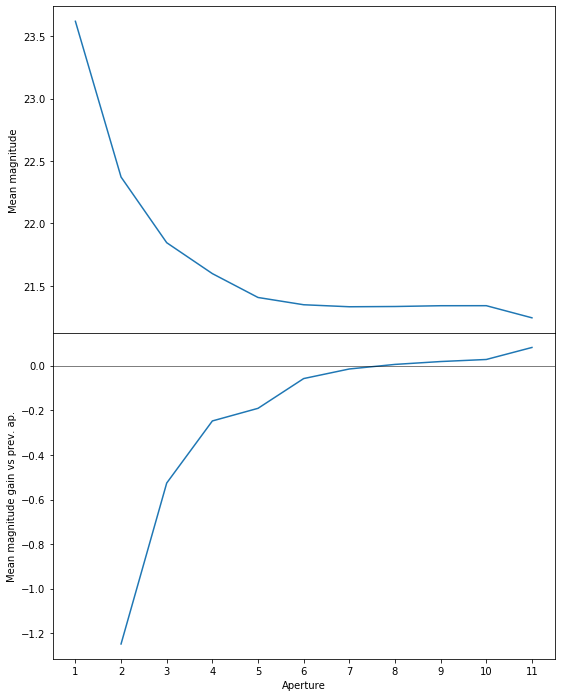

In [9]:

nb_plot_mag_ap_evol(magnitudes['r'], stellarities['r'], labels=apertures)

We will use aperture 10 as target.

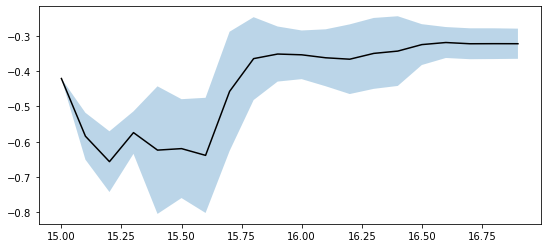

In [10]:

nb_plot_mag_vs_apcor(orig_des['MAG_APER_4_R'], orig_des['MAG_APER_10_R'], stellarities['r'])

We use magnitudes between 15.0 and 16.0.

In [11]:
# Aperture correction
mag_corr['r'], num, std = aperture_correction(
    orig_des['MAG_APER_4_R'], orig_des['MAG_APER_10_R'], 
    stellarities['r'],
    mag_min=15.0, mag_max=16.0)
print("Aperture correction for r band:")
print("Correction: {}".format(mag_corr['r']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for r band:
Correction: -0.3793330192565918
Number of source used: 1274
RMS: 0.13115655264315917


### I.b - i band

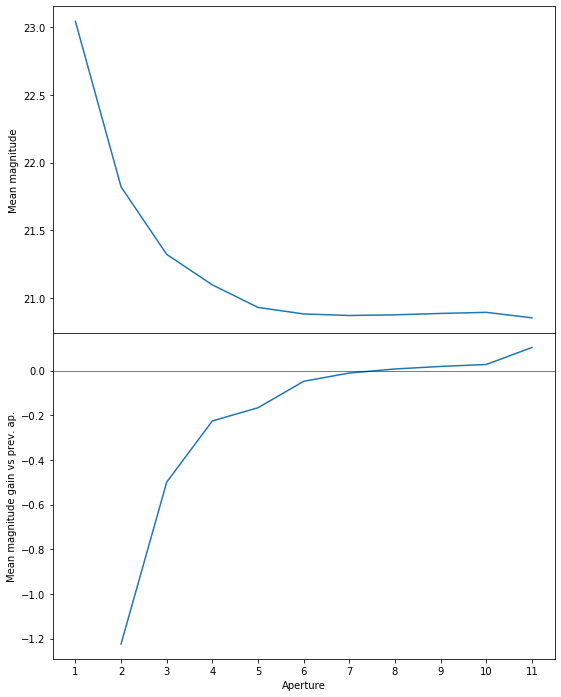

In [12]:
nb_plot_mag_ap_evol(magnitudes['i'], stellarities['i'], labels=apertures)

We will use aperture 10 as target.

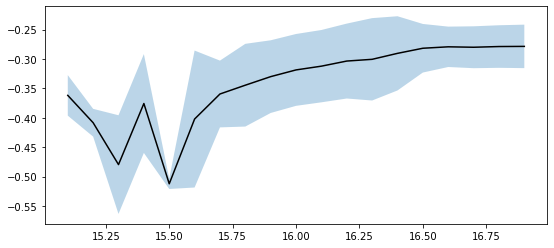

In [13]:
nb_plot_mag_vs_apcor(orig_des['MAG_APER_4_I'], orig_des['MAG_APER_10_I'], stellarities['i'])

We use magnitudes between 15.0 and 16.0.

In [14]:
# Aperture correction
mag_corr['i'], num, std = aperture_correction(
    orig_des['MAG_APER_4_I'], orig_des['MAG_APER_10_I'], 
    stellarities['i'],
    mag_min=15.0, mag_max=16.0)
print("Aperture correction for i band:")
print("Correction: {}".format(mag_corr['i']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for i band:
Correction: -0.3366975784301758
Number of source used: 1135
RMS: 0.061604339289693305


### I.b - z band

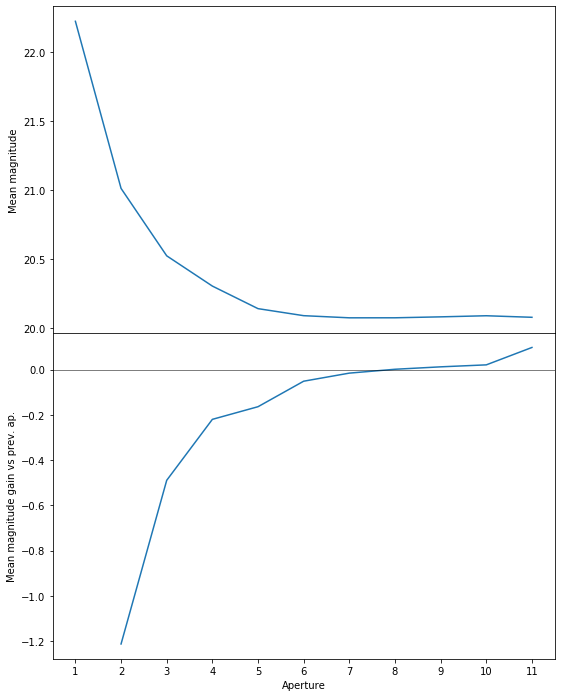

In [15]:

nb_plot_mag_ap_evol(magnitudes['z'], stellarities['z'], labels=apertures)

We will use aperture 57 as target.

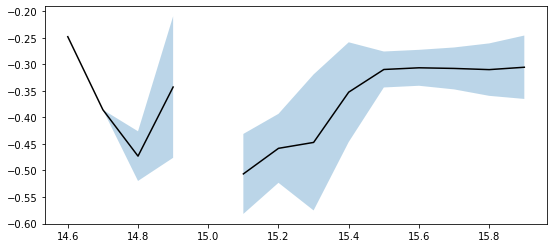

In [16]:

nb_plot_mag_vs_apcor(orig_des['MAG_APER_4_Z'], orig_des['MAG_APER_10_Z'], stellarities['z'])

We use magnitudes between 15.0 and 16.0.

In [17]:
# Aperture correction
mag_corr['z'], num, std = aperture_correction(
    orig_des['MAG_APER_4_Z'], orig_des['MAG_APER_10_Z'], 
    stellarities['z'],
    mag_min=15.0, mag_max=16.0)
print("Aperture correction for z band:")
print("Correction: {}".format(mag_corr['z']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for z band:
Correction: -0.3069114685058594
Number of source used: 4698
RMS: 0.04694057854818296


### I.b - y band

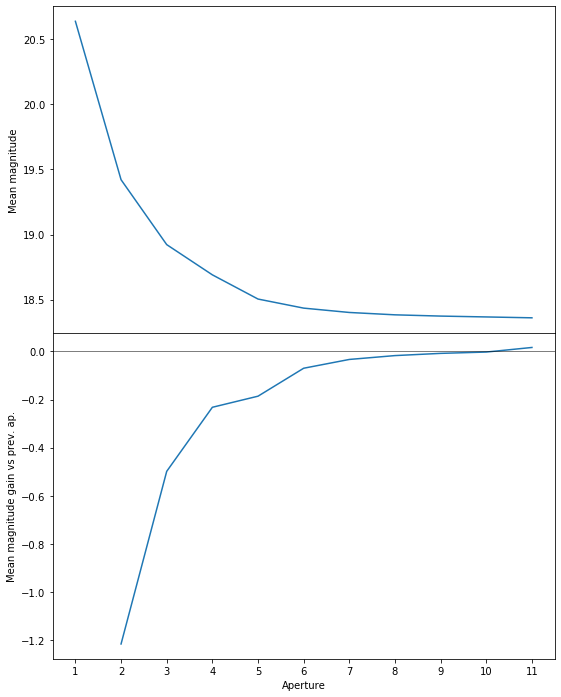

In [18]:
nb_plot_mag_ap_evol(magnitudes['y'], stellarities['y'], labels=apertures)

We will use aperture 10 as target.

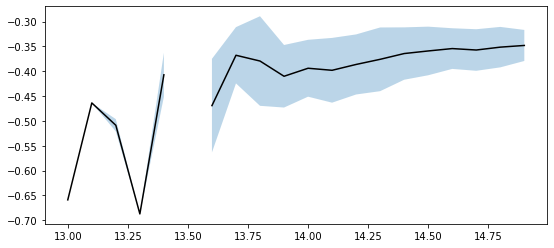

In [19]:

nb_plot_mag_vs_apcor(orig_des['MAG_APER_4_Y'], orig_des['MAG_APER_10_Y'], stellarities['y'])


We use magnitudes between 15.0 and 16.0.

In [20]:
# Aperture correction
mag_corr['y'], num, std = aperture_correction(
    orig_des['MAG_APER_4_Y'], orig_des['MAG_APER_10_Y'], 
    stellarities['y'],
    mag_min=15.0, mag_max=16.0)
print("Aperture correction for y band:")
print("Correction: {}".format(mag_corr['y']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for y band:
Correction: -0.3458409309387207
Number of source used: 5929
RMS: 0.030287634719868645


## 2 - Column selection

In [21]:

imported_columns = OrderedDict({
        'COADD_OBJECT_ID': "des_id",
        'RA': "des_ra",
        'DEC': "des_dec",
        'CLASS_STAR_G':  "des_stellarity",
    
        'MAG_AUTO_G': "m_decam_g", 
        'MAGERR_AUTO_G': "merr_decam_g", 
        'MAG_APER_4_G': "m_ap_decam_g", 
        'MAGERR_APER_4_G': "merr_ap_decam_g",
    
        'MAG_AUTO_R': "m_decam_r", 
        'MAGERR_AUTO_R': "merr_decam_r", 
        'MAG_APER_4_R': "m_ap_decam_r", 
        'MAGERR_APER_4_R': "merr_ap_decam_r",
    
        'MAG_AUTO_I': "m_decam_i", 
        'MAGERR_AUTO_I': "merr_decam_i", 
        'MAG_APER_4_I': "m_ap_decam_i", 
        'MAGERR_APER_4_I': "merr_ap_decam_i",
    
        'MAG_AUTO_Z': "m_decam_z", 
        'MAGERR_AUTO_Z': "merr_decam_z", 
        'MAG_APER_4_Z': "m_ap_decam_z", 
        'MAGERR_APER_4_Z': "merr_ap_decam_z",
    
        'MAG_AUTO_Y': "m_decam_y", 
        'MAGERR_AUTO_Y': "merr_decam_y", 
        'MAG_APER_4_Y': "m_ap_decam_y", 
        'MAGERR_APER_4_Y': "merr_ap_decam_y",

    })


catalogue = Table.read(INPUT_CAT)[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

# Clean table metadata
catalogue.meta = None

In [22]:
# Aperture correction
for band in bands:
    catalogue["m_ap_decam_{}".format(band)] += mag_corr[band]

In [23]:
# Adding flux and band-flag columns
for col in catalogue.colnames:

            
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # Some objects have -99.0 values
        mask = (catalogue[col] > 50.) | (catalogue[col] < 0.)
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
            
        # Fluxes are added in ÂµJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.            
        


In [24]:
catalogue[:10].show_in_notebook()

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [25]:
SORT_COLS = ['merr_ap_decam_g', 'merr_ap_decam_r','merr_ap_decam_i','merr_ap_decam_z','merr_ap_decam_y']
FLAG_NAME = 'des_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 3323362 sources.
The cleaned catalogue has 3323315 sources (47 removed).
The cleaned catalogue has 47 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [27]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_AKARI-SEP.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

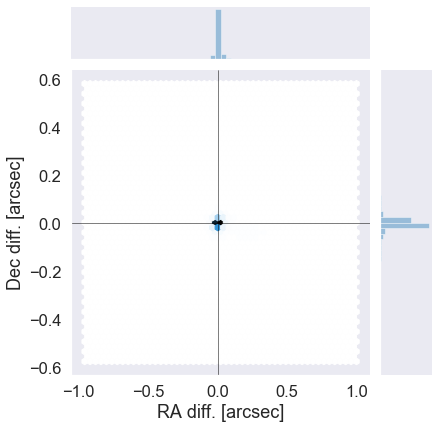

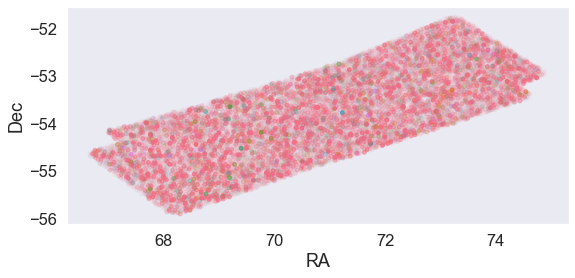

In [28]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [29]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.0029035745967576077 arcsec
Dec correction: -0.0009007351280843068 arcsec


In [30]:
catalogue[RA_COL] = catalogue[RA_COL] + delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

In [31]:
catalogue[RA_COL].unit = u.deg
catalogue[DEC_COL].unit = u.deg

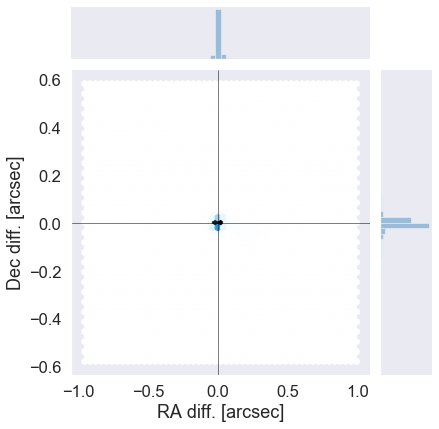

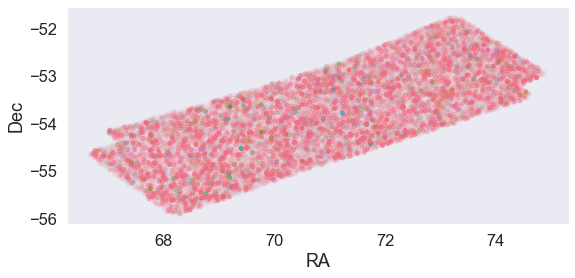

In [32]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [33]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [34]:
GAIA_FLAG_NAME = "des_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

39269 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [35]:
catalogue.write("{}/DES_DR2.fits".format(OUT_DIR), overwrite=True)